<a href="https://colab.research.google.com/github/Yohan0358/Study_GAN/blob/main/GAN(210713).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader

from torchvision import transforms, datasets
from torchvision import utils

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device type : ', device)

# Hyper-parameters
latent_size = 64
hidden_size = 256
image_size = 28 * 28
epochs = 100
batch_size = 100
lr = 0.0002

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(
                                    mean = [0.5], std = [0.5])   # 1 channel
                                ])

device type :  cuda


In [ ]:
# 데이터 다운로드
mnist = datasets.MNIST('./mnist/',
                       train = True,
                       transform = transform,
                       download = True)

# dataloader
data_loader = DataLoader(mnist, 
                         batch_size = batch_size, 
                         shuffle = True)

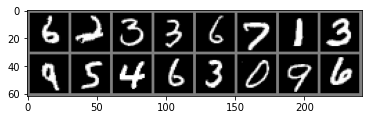

In [ ]:
def imshow(img):
    img = (img + 1) / 2
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap = 'gray')
    plt.show()

def imshow_grid(img):
    img = utils.make_grid(img.cpu().detach())
    img = (img + 1) / 2
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

ex_batch_img, _ = next(iter(data_loader))
imshow_grid(ex_batch_img[:16, :])

In [ ]:
# Generator
class Generator(nn.Module):
    def __init__(self, latent_size = latent_size, hidden_size = hidden_size, image_size = image_size):
        super(Generator, self).__init__()
        self.lin1 = nn.Linear(latent_size, hidden_size)
        self.lin2 = nn.Linear(hidden_size, hidden_size)
        self.lin3 = nn.Linear(hidden_size, image_size)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.leakyrelu(self.lin1(x))
        x = self.leakyrelu(self.lin2(x))
        x = nn.Tanh()(self.lin3(x))
        return x


class Descriminator(nn.Module):
    def __init__(self, input_size = image_size, hidden_size = hidden_size):
        super(Descriminator, self).__init__()

        self.lin1 = nn.Linear(input_size, hidden_size)
        self.lin2 = nn.Linear(hidden_size, hidden_size)
        self.lin3 = nn.Linear(hidden_size, 1)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.leakyrelu(self.lin1(x))
        x = self.leakyrelu(self.lin2(x))
        x = nn.Sigmoid()(self.lin3(x))
        return x

In [ ]:
# noise define
def generate_noise(latent_size = latent_size, batch_size = batch_size):
    return torch.randn(batch_size, latent_size)

z = generate_noise().to(device)

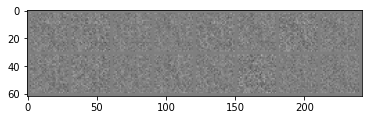

In [ ]:
G = Generator().to(device)
D = Descriminator().to(device)
img_fake = G(z).view(-1, 1, 28, 28)

imshow_grid(img_fake[:16])

In [ ]:
# Optimizer
G_optim = torch.optim.Adam(G.parameters(), lr = lr)
D_optim = torch.optim.Adam(D.parameters(), lr = lr)

# Loss function
criterion = nn.BCELoss()

In [ ]:
# training

def GAN_train(epochs = epochs):
    dloss_list = []
    gloss_list = []
    for epoch in range(epochs):
        d_losses = 0
        g_losses = 0
        for i, (image, _) in enumerate(data_loader):

            image = image.view(-1, 28 * 28 ).to(device)

            z = generate_noise().to(device)

            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            # Descriminator 학습

            real_loss = criterion(D(image), real_labels)
            fake_loss = criterion(D(G(z)), fake_labels)

            d_loss = real_loss + fake_loss

            D_optim.zero_grad()
            d_loss.backward()
            D_optim.step()



            # Generator 학습

            g_loss = criterion(D(G(z)), real_labels)
            G_optim.zero_grad()
            g_loss.backward()
            G_optim.step()

            d_losses += d_loss / len(data_loader)
            g_losses += g_loss / len(data_loader)

        print(f'[{epoch + 1} / {epochs}] D_loss : {d_losses:.4f} \t G_loss : {g_losses:.4f}')     
        if (epoch + 1) % 20 == 0:
            imshow_grid(G(z).view(-1, 1, 28, 28)[:16])

      dloss_list.append(d_losses)
      gloss_list.append(g_losses)

    return dloss_list, gloss_list

[1 / 100] D_loss : 0.4095 	 G_loss : 3.0457
[2 / 100] D_loss : 0.4277 	 G_loss : 3.2430
[3 / 100] D_loss : 0.8402 	 G_loss : 2.4530
[4 / 100] D_loss : 0.8296 	 G_loss : 1.9733
[5 / 100] D_loss : 0.5721 	 G_loss : 2.6122
[6 / 100] D_loss : 0.7895 	 G_loss : 2.4722
[7 / 100] D_loss : 0.7528 	 G_loss : 2.7184
[8 / 100] D_loss : 0.5256 	 G_loss : 2.8913
[9 / 100] D_loss : 0.5605 	 G_loss : 2.6065
[10 / 100] D_loss : 0.5386 	 G_loss : 2.9426
[11 / 100] D_loss : 0.7386 	 G_loss : 2.9597
[12 / 100] D_loss : 0.7128 	 G_loss : 2.4081
[13 / 100] D_loss : 0.5100 	 G_loss : 3.0315
[14 / 100] D_loss : 0.4306 	 G_loss : 3.4602
[15 / 100] D_loss : 0.5763 	 G_loss : 2.8700
[16 / 100] D_loss : 0.5792 	 G_loss : 2.9869
[17 / 100] D_loss : 0.5729 	 G_loss : 2.7250
[18 / 100] D_loss : 0.5462 	 G_loss : 3.0737
[19 / 100] D_loss : 0.5537 	 G_loss : 3.0648
[20 / 100] D_loss : 0.5071 	 G_loss : 3.1487


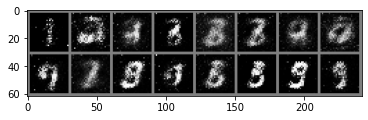

[21 / 100] D_loss : 0.5426 	 G_loss : 3.1036
[22 / 100] D_loss : 0.4886 	 G_loss : 2.9318
[23 / 100] D_loss : 0.5104 	 G_loss : 2.8886
[24 / 100] D_loss : 0.5419 	 G_loss : 2.5267
[25 / 100] D_loss : 0.5526 	 G_loss : 2.4740
[26 / 100] D_loss : 0.6113 	 G_loss : 2.5283
[27 / 100] D_loss : 0.6130 	 G_loss : 2.5957
[28 / 100] D_loss : 0.6642 	 G_loss : 2.3645
[29 / 100] D_loss : 0.6442 	 G_loss : 2.5063
[30 / 100] D_loss : 0.6765 	 G_loss : 2.4507
[31 / 100] D_loss : 0.6940 	 G_loss : 2.2252
[32 / 100] D_loss : 0.7278 	 G_loss : 2.1444
[33 / 100] D_loss : 0.7200 	 G_loss : 2.2111
[34 / 100] D_loss : 0.7097 	 G_loss : 2.1880
[35 / 100] D_loss : 0.7263 	 G_loss : 2.0669
[36 / 100] D_loss : 0.7263 	 G_loss : 2.0742
[37 / 100] D_loss : 0.6963 	 G_loss : 2.1407
[38 / 100] D_loss : 0.6666 	 G_loss : 2.2583
[39 / 100] D_loss : 0.7121 	 G_loss : 2.1828
[40 / 100] D_loss : 0.7135 	 G_loss : 2.1352


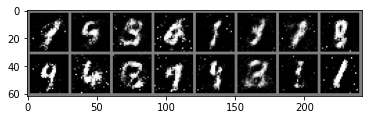

[41 / 100] D_loss : 0.7073 	 G_loss : 2.1174
[42 / 100] D_loss : 0.7304 	 G_loss : 2.0790
[43 / 100] D_loss : 0.7413 	 G_loss : 2.0432
[44 / 100] D_loss : 0.7473 	 G_loss : 1.9939
[45 / 100] D_loss : 0.7447 	 G_loss : 1.9497
[46 / 100] D_loss : 0.7567 	 G_loss : 1.9885
[47 / 100] D_loss : 0.7500 	 G_loss : 1.9719
[48 / 100] D_loss : 0.7724 	 G_loss : 1.9690
[49 / 100] D_loss : 0.7603 	 G_loss : 1.9789
[50 / 100] D_loss : 0.7572 	 G_loss : 1.9172
[51 / 100] D_loss : 0.7799 	 G_loss : 1.9301
[52 / 100] D_loss : 0.7622 	 G_loss : 1.8898
[53 / 100] D_loss : 0.7629 	 G_loss : 1.9229
[54 / 100] D_loss : 0.7660 	 G_loss : 1.9329
[55 / 100] D_loss : 0.7908 	 G_loss : 1.8953
[56 / 100] D_loss : 0.7558 	 G_loss : 1.9377
[57 / 100] D_loss : 0.7820 	 G_loss : 1.8792
[58 / 100] D_loss : 0.7751 	 G_loss : 1.8719
[59 / 100] D_loss : 0.7835 	 G_loss : 1.8664
[60 / 100] D_loss : 0.7869 	 G_loss : 1.8494


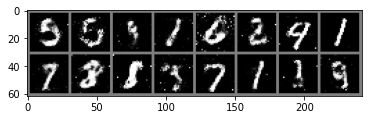

[61 / 100] D_loss : 0.8023 	 G_loss : 1.8293
[62 / 100] D_loss : 0.7982 	 G_loss : 1.8287
[63 / 100] D_loss : 0.8090 	 G_loss : 1.8189
[64 / 100] D_loss : 0.8116 	 G_loss : 1.8511
[65 / 100] D_loss : 0.8206 	 G_loss : 1.8054
[66 / 100] D_loss : 0.8238 	 G_loss : 1.7949
[67 / 100] D_loss : 0.8277 	 G_loss : 1.7958
[68 / 100] D_loss : 0.8288 	 G_loss : 1.7372
[69 / 100] D_loss : 0.8300 	 G_loss : 1.7873
[70 / 100] D_loss : 0.8370 	 G_loss : 1.7914
[71 / 100] D_loss : 0.8285 	 G_loss : 1.7976
[72 / 100] D_loss : 0.8296 	 G_loss : 1.7886
[73 / 100] D_loss : 0.8365 	 G_loss : 1.7593
[74 / 100] D_loss : 0.8348 	 G_loss : 1.7402
[75 / 100] D_loss : 0.8489 	 G_loss : 1.7390
[76 / 100] D_loss : 0.8504 	 G_loss : 1.7323
[77 / 100] D_loss : 0.8480 	 G_loss : 1.6999
[78 / 100] D_loss : 0.8500 	 G_loss : 1.7357
[79 / 100] D_loss : 0.8500 	 G_loss : 1.7211
[80 / 100] D_loss : 0.8548 	 G_loss : 1.6921


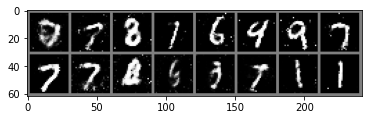

[81 / 100] D_loss : 0.8579 	 G_loss : 1.7013
[82 / 100] D_loss : 0.8588 	 G_loss : 1.6854
[83 / 100] D_loss : 0.8588 	 G_loss : 1.7098
[84 / 100] D_loss : 0.8569 	 G_loss : 1.6927
[85 / 100] D_loss : 0.8663 	 G_loss : 1.6809
[86 / 100] D_loss : 0.8656 	 G_loss : 1.6815
[87 / 100] D_loss : 0.8645 	 G_loss : 1.6860
[88 / 100] D_loss : 0.8674 	 G_loss : 1.6610
[89 / 100] D_loss : 0.8656 	 G_loss : 1.7054
[90 / 100] D_loss : 0.8644 	 G_loss : 1.6994
[91 / 100] D_loss : 0.8652 	 G_loss : 1.6854
[92 / 100] D_loss : 0.8646 	 G_loss : 1.6753
[93 / 100] D_loss : 0.8596 	 G_loss : 1.6891
[94 / 100] D_loss : 0.8679 	 G_loss : 1.6768
[95 / 100] D_loss : 0.8617 	 G_loss : 1.6757
[96 / 100] D_loss : 0.8585 	 G_loss : 1.6422
[97 / 100] D_loss : 0.8602 	 G_loss : 1.6863
[98 / 100] D_loss : 0.8535 	 G_loss : 1.6761
[99 / 100] D_loss : 0.8603 	 G_loss : 1.6938
[100 / 100] D_loss : 0.8558 	 G_loss : 1.7063


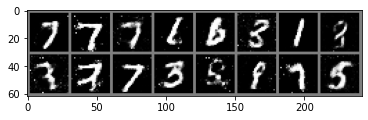

In [ ]:
dloss, gloss = GAN_train(100)

In [ ]:
# 모델 저장
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')